In this notebook we prepare the data (data cleaning and feature engineering) for modelling.

# Load modules and data

In [1]:
import category_encoders as ce
import gc
import matplotlib.pyplot as plt
import numpy as np 
import os
import pandas as pd
import pickle
import re
import seaborn as sns
import time
from collections import Counter
from itertools import product
from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder

pd.options.display.max_rows = None

Read all the data files

In [2]:
#items = pd.read_csv('kaggle/input/competitive-data-science-predict-future-sales/items.csv')
items = pd.read_csv('kaggle/input/competitive-data-science-predict-future-sales-eng-translation/items.csv')
#shops = pd.read_csv('kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
shops = pd.read_csv('kaggle/input/competitive-data-science-predict-future-sales-eng-translation/shops.csv')
train = pd.read_csv('kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
test = pd.read_csv('kaggle/input/competitive-data-science-predict-future-sales/test.csv')
sample_submission = pd.read_csv('kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv')
item_categories = pd.read_csv('kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')

Set the right time format.

In [3]:
train['date'] = pd.to_datetime(train['date'], format = '%d.%m.%Y')

In [4]:
train.date.min()

Timestamp('2013-01-01 00:00:00')

In [5]:
train.date.max()

Timestamp('2015-10-31 00:00:00')

# Outliers

<AxesSubplot:xlabel='item_price'>

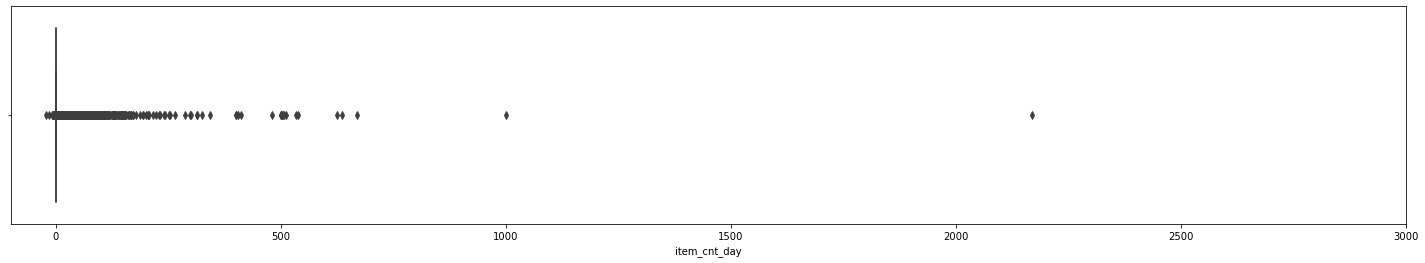

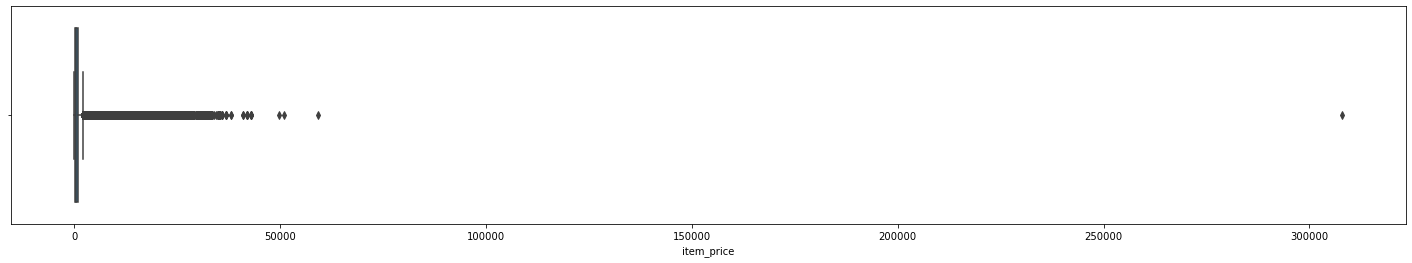

In [6]:
plt.figure(figsize = (25, 4))
plt.xlim(-100, 3000)
sns.boxplot(x = train.item_cnt_day)

plt.figure(figsize = (25, 4))
sns.boxplot(x = train.item_price)

We remove item counts and prices that are clearly outliers.

In [7]:
train = train[train.item_cnt_day < 1001]
train = train[train.item_price < 50000]

We also remove an item where item_price < 0.

In [8]:
train = train[train.item_price > 0]

There are duplicates of the shops' names, which we adjust for.

In [9]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

We remove shops that do not appear in the test set.

In [10]:
len(train[train['shop_id'].isin(test.shop_id.unique())]) / len(train)

0.8274540472858912

In [11]:
#train = train[train['shop_id'].isin(test.shop_id.unique())]

Add the first day the item was sold.

In [12]:
train['first_sale_day'] = train.date.dt.dayofyear 
train['first_sale_day'] += 365 * (train.date.dt.year - 2013)
train['first_sale_day'] = train.groupby('item_id')['first_sale_day'].transform('min').astype('int16')

Calculate the proportion of weekly sales that occurred on each weekday at each shop.

In [13]:
train['weekday'] = train.date.dt.dayofweek

temp = train.groupby(['shop_id','weekday']).agg({'item_cnt_day':'sum'}).reset_index()
temp = pd.merge(temp, train.groupby(['shop_id']).agg({'item_cnt_day':'sum'}).reset_index(), on = 'shop_id', \
                how = 'left')
temp.columns = ['shop_id','weekday', 'shop_day_sales', 'shop_total_sales']
temp['day_quality'] = temp['shop_day_sales'] / temp['shop_total_sales']
temp = temp[['shop_id','weekday','day_quality']]

dates = pd.DataFrame(data={'date':pd.date_range(start='2013-01-01',end='2015-11-30')})
dates['weekday'] = dates.date.dt.dayofweek
dates['month'] = dates.date.dt.month
dates['year'] = dates.date.dt.year - 2013
dates['date_block_num'] = dates['year']*12 + dates['month'] - 1
dates['first_day_of_month'] = dates.date.dt.dayofyear
dates['first_day_of_month'] += 365 * dates['year']
dates = dates.join(temp.set_index('weekday'), on='weekday')
dates = dates.groupby(['date_block_num','shop_id','month','year']).agg({'day_quality':'sum',\
                                                                        'first_day_of_month':'min'}).reset_index()

# Preprocessing of shops, categories and items

## Shops

In [14]:
shops.head()

,shop_name,shop_id
0,"! Yakutsk Ordzhonikidze, 56 francs",0
1,"! Yakutsk TC ""Central"" fran",1
2,"Adygea TC ""Mega""",2
3,"Balashikha TC ""Oktyabr-Kinomir""",3
4,"Volga TC ""Volga Mall""",4


We start by cleaning up shop_names.

Each shop_name starts with the name of the city the shop is located in (with some exceptions). 
This information might be important.

We can also extract the shop_type from shop_name

In [15]:
shops['shop_name'] = shops['shop_name'].str.lower()
shops['shop_name'] = shops['shop_name'].str.replace(r'[^\w\d\s]', '', regex = True)
shops['shop_name'] = shops['shop_name'].str.replace('sergiev posad', 'sergievposad')
shops['shop_name'] = shops['shop_name'].str.replace('st petersburg', 'stpetersburg')
shops['shop_name'] = shops['shop_name'].str.replace('rostovnadonu', 'rostovnadon')
shops['shop_name'] = shops['shop_name'].str.strip()

shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops['category'] = 'regular'

shops.loc[shops['shop_name'].str.contains(r'tc'), 'category'] = 'tc'
shops.loc[shops['shop_name'].str.contains(r'mall|center|mega'), 'category'] = 'mall'
shops.loc[shops['shop_id'].isin([9,20]), 'category'] = 'special'
shops.loc[shops['shop_id'].isin([12,55]), 'category'] = 'online'

shops.loc[shops['shop_id'].isin([12,55]), 'city'] = 'online'

shops.head()

,shop_name,shop_id,city,category
0,yakutsk ordzhonikidze 56 francs,0,yakutsk,regular
1,yakutsk tc central fran,1,yakutsk,tc
2,adygea tc mega,2,adygea,mall
3,balashikha tc oktyabrkinomir,3,balashikha,tc
4,volga tc volga mall,4,volga,mall


<AxesSubplot:xlabel='category', ylabel='count'>

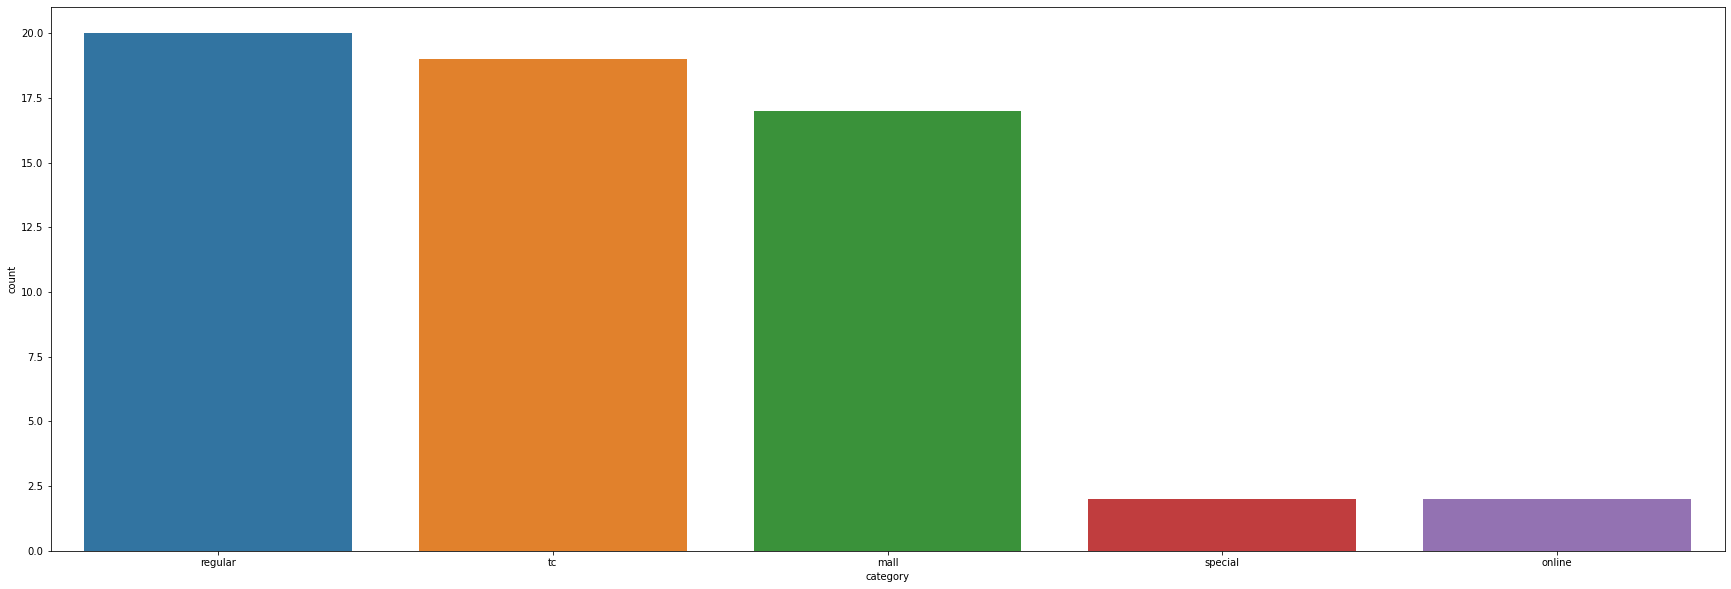

In [16]:
plt.figure(figsize = (30, 10))
sns.countplot(x = 'category', data = shops)

We only keep a category if there are 5 or more shops of that category, otherwise we set 'Other'.

In [17]:
#categories = []
#for cat in shops.category.unique():
#    if len(shops[shops.category == cat]) >= 5:
#        categories.append(cat)
#shops.category = shops.category.apply(lambda x: x if (x in categories) else 'Other')

In [18]:
#plt.figure(figsize = (30, 10))
#g = sns.countplot(x = 'city', data = shops)
#g.set_xticklabels(g.get_xticklabels(), rotation = 45)
#None

One city (Moscow) is found much more frequently than the others.

We only keep a city if there are 2 or more of them. 

**Note:** In the early xgb models we've trained, city_code was not used as a feature at all, so it's worth trying.

In [19]:
#cities = []
#for city in shops.city.unique():
#    if len(shops[shops.city == city]) >= 2:
#        cities.append(city)
#shops.city = shops.city.apply(lambda x: x if (x in cities) else 'Other')

shops[['city_code', 'category_code']] = OrdinalEncoder().fit_transform(shops[['city', 'category']])

shops = shops[["shop_id", "category_code", "city_code"]]

shops.head()

,shop_id,category_code,city_code
0,0,2.0,27.0
1,1,4.0,27.0
2,2,0.0,0.0
3,3,4.0,1.0
4,4,0.0,24.0


## Categories

In [20]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


Each category contains a type and subtype (with some exceptions). We also perform some cleaning

In [21]:
item_categories['split'] = item_categories['item_category_name'].str.split('-')
item_categories['type'] = item_categories['split'].map(lambda x: x[0].strip()) # All leading and trailing
# whitespaces are removed from the string
item_categories['subtype'] = item_categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
# If subtype is not available we set type as subtype.

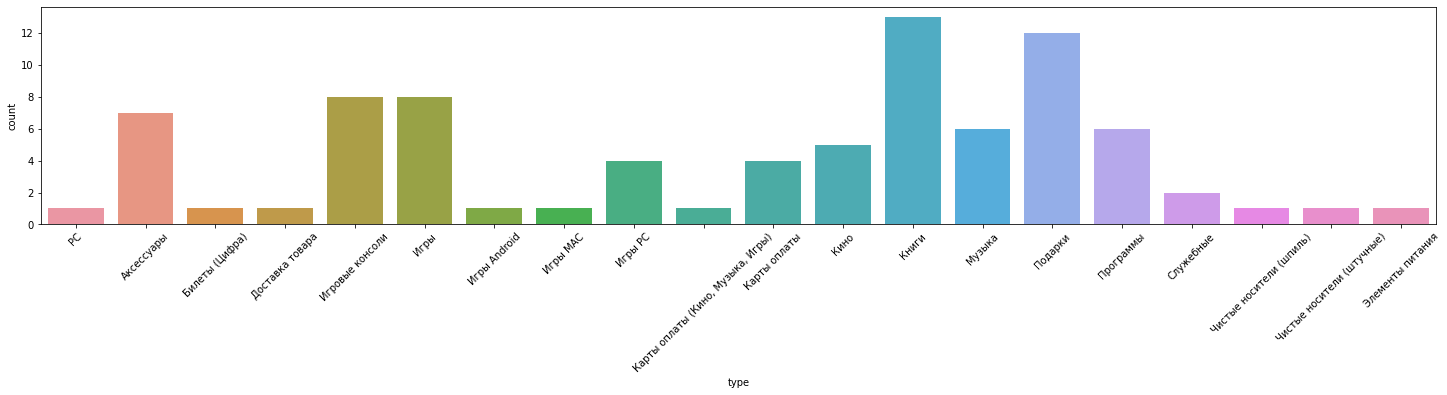

In [22]:
plt.figure(figsize = (25, 4))
g = sns.countplot(x = 'type', data = item_categories)
g.set_xticklabels(g.get_xticklabels(), rotation = 45)
None

We only keep a type if there are 5 or more of them. From the feature importances of the models we've already trained we know that this is not a very important feature, so binning might improve it.

In [23]:
#types = []
#for my_type in item_categories.type.unique():
#    if len(item_categories[item_categories.type == my_type]) >= 5: 
#        types.append(my_type)
#item_categories.type = item_categories.type.apply(lambda x: x if (x in types) else "Other")

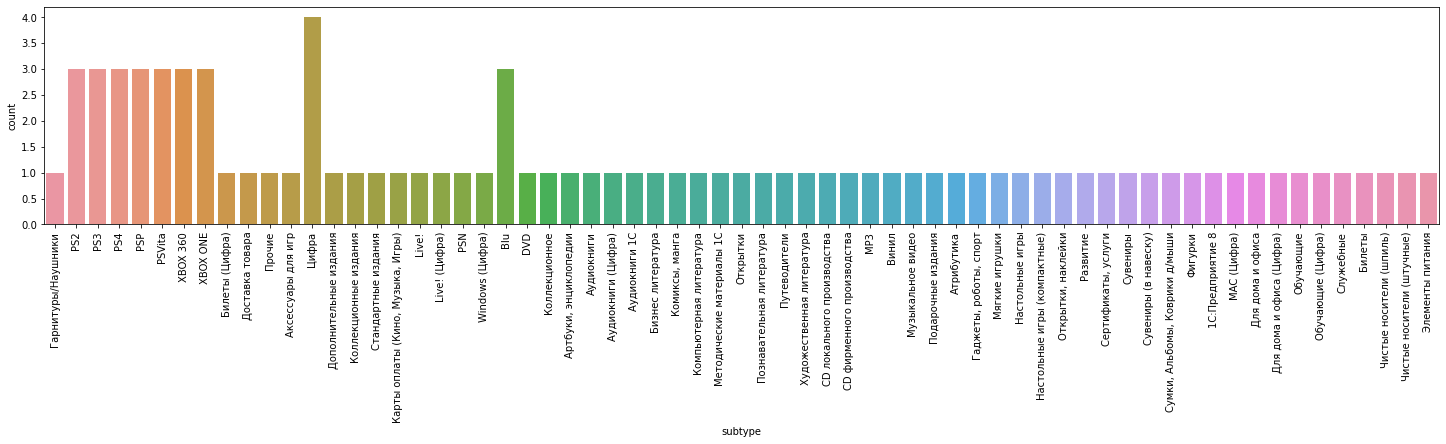

In [24]:
plt.figure(figsize = (25, 4))
g = sns.countplot(x = 'subtype', data = item_categories)
g.set_xticklabels(g.get_xticklabels(), rotation = 90)
None

From the models we have trained previously we can see that subtype is already quite important as a feature, so we leave it as it is.

In [25]:
#item_categories['type_code'] = OrdinalEncoder().fit_transform(item_categories.type.values.reshape(1, -1))[0]
#item_categories['subtype_code'] = OrdinalEncoder().fit_transform(item_categories.subtype.values.reshape(1, -1))[0]

item_categories[['type_code', 'subtype_code']] = OrdinalEncoder().fit_transform(item_categories[['type', \
                                                                                                 'subtype']])

item_categories = item_categories[['item_category_id','type_code', 'subtype_code']]

item_categories.head()

,item_category_id,type_code,subtype_code
0,0,0.0,29.0
1,1,1.0,9.0
2,2,1.0,10.0
3,3,1.0,11.0
4,4,1.0,13.0


## Items

In [26]:
items.head()

,item_id,category_id,item_name
0,0,40,!! IN THE POWER OF HAPPINESS (PLAST) D
1,1,76,! ABBYY FineReader 12 Professional Edition Ful...
2,2,40,*** IN THE GLORY OF THE GLORY (UNV) D
3,3,40,*** BLUE WAVE (Univ) D
4,4,40,*** BOX (GLASS) D


We will do some corrections of item_name.

In [27]:
def name_correction(x):
    x = x.lower() # Make all letters lower case.
    x = x.partition('[')[0] # Partition by square brackets.
    x = x.partition('(')[0] # Partition by curly brackets.
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x) # Remove special characters.
    x = x.replace('  ', ' ') # Replace double spaces with single spaces.
    x = x.strip() # Remove leading and trailing white space.
    x = x.replace('.', '')
    return x

Split item_name into two parts (depending on which type of bracket is found).

In [28]:
items[["item_name1", "item_name2"]] = items.item_name.str.split("[", 1, expand = True)
items[["item_name1", "item_name3"]] = items.item_name.str.split("(", 1, expand = True)

items["item_name2"] = items.item_name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ", regex = True).str.lower()
items["item_name3"] = items.item_name3.str.replace('[^A-Za-z0-9А-Яа-я]+', " ", regex = True).str.lower()

items = items.fillna('0')

Clean and simplify item_name, and create a new feature consisting of the first eleven characters of the string.

In [29]:
items["item_name"] = items["item_name"].apply(lambda x: name_correction(x))

for i in [r'[^\w\d\s\.]', r'\bthe\b', r'\bin\b', r'\bis\b', r'\bfor\b', r'\bof\b', r'\bon\b', r'\band\b',r'\bto\b',
          r'\bwith\b' , r'\byo\b']:
    items['item_name'] = items['item_name'].str.replace(i, ' ', regex = True)
    
items['item_name'] = items['item_name'].str.replace(r'\b.\b', ' ', regex = True)

items['item_name_no_space'] = items['item_name'].str.replace(' ', '')


items['item_name_first4'] = [x[:4] for x in items['item_name_no_space']]

items['item_name_first6'] = [x[:6] for x in items['item_name_no_space']]

items['item_name_first11'] = [x[:11] for x in items['item_name_no_space']]

del items['item_name_no_space']

items.head()

,item_id,category_id,item_name,item_name1,item_name2,item_name3,item_name_first4,item_name_first6,item_name_first11
0,0,40,power happiness,!! IN THE POWER OF HAPPINESS,0,plast d,powe,powerh,powerhappin
1,1,76,abbyy finereader 12 professional edition full,! ABBYY FineReader 12 Professional Edition Ful...,pc digital version,0,abby,abbyyf,abbyyfinere
2,2,40,glory glory,*** IN THE GLORY OF THE GLORY,0,unv d,glor,gloryg,gloryglory
3,3,40,blue wave,*** BLUE WAVE,0,univ d,blue,bluewa,bluewave
4,4,40,box,*** BOX,0,glass d,box,box,box


Set type column and clean it.

In [30]:
items["type"] = items.item_name2.apply(lambda x: x[0:8] if x.split(" ")[0] == "xbox" else x.split(" ")[0] )
items.loc[(items.type == "x360") | (items.type == "xbox360") | (items.type == "xbox 360") , "type"] = "xbox 360"
items.loc[items.type == "", "type"] = "mac"
items.type = items.type.apply(lambda x: x.replace(" ", ""))
items.loc[(items.type == 'pc' ) | (items.type == 'pс') | (items.type == "pc"), "type"] = "pc"
items.loc[items.type == 'рs3', "type"] = "ps3"

'0' and 'pc' occur much more frequently than the other categories, so we don't plot them.

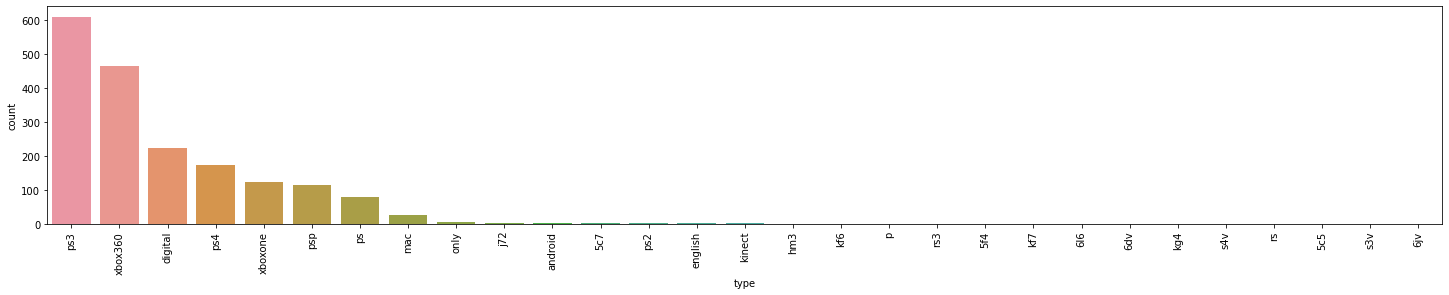

In [31]:
plt.figure(figsize = (25, 4))
g = sns.countplot(x = "type", data = items[~items.type.isin(["0", "pc"])], \
                  order = items[~items.type.isin(["0", "pc"])]['type'].value_counts().index)
g.set_xticklabels(g.get_xticklabels(), rotation = 90)
None

We only consider types that occur more than 40 times.

In [32]:
group_sum = items.groupby(["type"]).agg({"item_id": "count"})
group_sum = group_sum.reset_index()
#drop_cats = []
#for cat in group_sum.type.unique():
#    if group_sum.loc[(group_sum.type == cat), "item_id"].values[0] <= 40:
#        drop_cats.append(cat)
#items.item_name2 = items.item_name2.apply(lambda x: "Other" if (x in drop_cats) else x )
items = items.drop(["type"], axis = 1)

#items.item_name2 = OrdinalEncoder().fit_transform(items.item_name2.values.reshape(1, -1))[0]
#items.item_name3 = OrdinalEncoder().fit_transform(items.item_name3.values.reshape(1, -1))[0]

items[['item_name2', 'item_name3', 'item_name_first4', 'item_name_first6', 'item_name_first11']] = \
OrdinalEncoder().fit_transform(items[['item_name2', 'item_name3', 'item_name_first4', 'item_name_first6', \
                                      'item_name_first11']])

#items = items.drop(["item_name", "item_name1"], axis = 1)
items = items.drop("item_name1", axis = 1)

items.head()

,item_id,category_id,item_name,item_name2,item_name3,item_name_first4,item_name_first6,item_name_first11
0,0,40,power happiness,2.0,1315.0,2572.0,4575.0,7822.0
1,1,76,abbyy finereader 12 professional edition full,46.0,37.0,121.0,152.0,230.0
2,2,40,glory glory,2.0,1641.0,1330.0,2405.0,4236.0
3,3,40,blue wave,2.0,1640.0,508.0,887.0,1445.0
4,4,40,box,2.0,960.0,546.0,965.0,1619.0


There are duplicate row in the item list.
We reassign item_ids where appropriate.

In [33]:
dupes = items[(items.duplicated(subset = ['item_name', 'category_id'], keep = False))].copy()
dupes['in_test'] = dupes.item_id.isin(test.item_id.unique())
dupes.head(14)

,item_id,category_id,item_name,item_name2,item_name3,item_name_first4,item_name_first6,item_name_first11,in_test
32,32,40,,2.0,37.0,0.0,0.0,0.0,True
35,35,40,10 years later,2.0,37.0,13.0,16.0,25.0,False
37,37,40,10 years later,2.0,1399.0,13.0,16.0,25.0,False
84,84,40,127 hours,2.0,37.0,17.0,20.0,29.0,False
86,86,40,127 hours,2.0,1399.0,17.0,20.0,29.0,False
98,98,40,1812 ulanska ballada,2.0,37.0,28.0,35.0,45.0,False
100,100,40,1812 ulanska ballada,2.0,1399.0,28.0,35.0,45.0,False
127,127,44,1c audiobooks fairy tales release,13.0,37.0,31.0,38.0,48.0,False
128,128,44,1c audiobooks fairy tales release,13.0,37.0,31.0,38.0,48.0,False
129,129,44,1c audiobooks fairy tales release,13.0,37.0,31.0,38.0,48.0,False


In [34]:
dupes = dupes.groupby('item_name').agg({'item_id':['first', 'last'], 'in_test':['first', 'last']})
#dupes.head(14)

If both item_ids are in the test set we do nothing.

In [35]:
dupes = dupes[(dupes[('in_test', 'first')] == False) | (dupes[('in_test', 'last')] == False)]
#dupes.head(14)

If only the first id is in the test set we assign it to both.

In [36]:
temp = dupes[dupes[('in_test', 'first')] == True]
keep_first = dict(zip(temp[('item_id', 'last')], temp[('item_id', 'first')]))

If only the second id is in the test set, assign it to both.

In [37]:
temp = dupes[dupes[('in_test', 'first')] == False]
keep_second = dict(zip(temp[('item_id', 'first')], temp[('item_id', 'last')]))
item_map = {**keep_first, **keep_second}

In [38]:
train = train.replace({'item_id':item_map})

# Monthly aggregation of data and feature engineering

Add revenue as a feature.

In [39]:
train['revenue'] = train['item_cnt_day'] * train['item_price']

Consider all possible pairs of item/shop in each date_block_num.

In [40]:
index_cols = ['date_block_num', 'shop_id', 'item_id']

# For every month we create a grid for all shop/item combinations from that month.
grid = [] 
ts = time.time()
for block_num in train['date_block_num'].unique():
    cur_shops = train[train['date_block_num'] == block_num]['shop_id'].unique()
    cur_items = train[train['date_block_num'] == block_num]['item_id'].unique()
    grid.append(np.array(list(product([block_num], cur_shops, cur_items)), dtype = 'int16'))

# Turn the grid into a pandas dataframe.
grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype = np.int32)

grid.sort_values(index_cols, inplace = True)
time.time() - ts

11.04143738746643

Adjust the test set - add date_block_num = 34 (November 2015).

In [41]:
test["date_block_num"] = 34

Concatenate train and test sets to make it easier to add features.

In [42]:
grid = pd.concat([grid, test.drop("ID", axis = 1)], ignore_index = True, sort = False, keys = index_cols)

## Add shops, items and item_categories features.

Add features related to the id of shops, items and categories.

In [43]:
ts = time.time()
#grid = pd.merge(grid, shops, on = ['shop_id'], how = 'left')
grid = pd.merge(grid, items.drop("item_name", axis = 1), on = 'item_id', how = 'left')
#grid = pd.merge(grid, item_categories, on = ['item_category_id'], how = 'left')
grid = pd.merge(grid, item_categories, left_on = 'category_id', right_on = 'item_category_id', how = 'left')
time.time() - ts

2.449554204940796

We also add features from the dataframe dates.

In [44]:
grid = pd.merge(grid, dates.drop('month', axis = 1), on = ['date_block_num','shop_id'], how = 'left')

In [45]:
grid.head()

,date_block_num,shop_id,item_id,category_id,item_name2,item_name3,item_name_first4,item_name_first6,item_name_first11,item_category_id,type_code,subtype_code,year,day_quality,first_day_of_month
0,0,2,19,40,2.0,37.0,1353.0,2435.0,4284.0,40,11.0,4.0,0,4.381744,1
1,0,2,27,19,87.0,37.0,2.0,2.0,2.0,19,5.0,10.0,0,4.381744,1
2,0,2,28,30,64.0,37.0,2.0,2.0,2.0,30,8.0,55.0,0,4.381744,1
3,0,2,29,23,129.0,37.0,2.0,2.0,2.0,23,5.0,16.0,0,4.381744,1
4,0,2,32,40,2.0,37.0,0.0,0.0,0.0,40,11.0,4.0,0,4.381744,1


## Add  age related features

In [46]:
ts = time.time()
train_monthly = train.groupby(index_cols).agg({'first_sale_day':['first']})
train_monthly.columns = ['first_sale_day']
train_monthly = train_monthly.reset_index()
grid = pd.merge(grid, train_monthly, on = index_cols, how = "left").fillna(0)
time.time() - ts

7.20256495475769

In [47]:
ts = time.time()
grid['first_sale_day'] = grid.groupby('item_id')['first_sale_day'].transform('max').astype('int16')
grid.loc[grid['first_sale_day'] == 0, 'first_sale_day'] = 1035 # first_day_of_month for date_block_num = 34
grid['prev_days_on_sale'] = [max(idx) for idx in zip(grid['first_day_of_month'] - grid['first_sale_day'], \
                                                     [0] * len(grid))]
del grid['first_day_of_month']
time.time() - ts

5.948408603668213

In [48]:
ts = time.time()
grid['item_age'] = (grid['date_block_num'] - grid.groupby('item_id')['date_block_num'].transform('min'))\
.astype('int8')

grid['item_name_first4_age'] = (grid['date_block_num'] - grid.groupby('item_name_first4')['date_block_num']\
                                 .transform('min')).astype('int8')

grid['item_name_first6_age'] = (grid['date_block_num'] - grid.groupby('item_name_first6')['date_block_num']\
                                 .transform('min')).astype('int8')

grid['item_name_first11_age'] = (grid['date_block_num'] - grid.groupby('item_name_first11')['date_block_num']\
                                 .transform('min')).astype('int8')

grid['category_age'] = (grid['date_block_num'] - grid.groupby('category_id')['date_block_num'].transform('min'))\
.astype('int8')

grid['type_age'] = (grid['date_block_num'] - grid.groupby('type_code')['date_block_num'].transform('min'))\
.astype('int8')

grid['shop_age'] = (grid['date_block_num'] - grid.groupby('shop_id')['date_block_num'].transform('min'))\
.astype('int8')
time.time() - ts

2.059041738510132

## Target variable and target lags

Obtain the target.

In [49]:
ts = time.time()
train_monthly = train.groupby(index_cols).agg({'item_cnt_day':['sum']})
train_monthly.columns = ['item_cnt_month_shop_item']
train_monthly = train_monthly.reset_index()
grid = pd.merge(grid, train_monthly, on = index_cols, how = "left" )
time.time() - ts

7.046042442321777

Fill NaNs with 0 in the target and clip to the range [0, 20] (the range that will be considered on evaluation).
We also keep an unclipped version.

In [50]:
grid['item_cnt_month_shop_item_unclipped'] = grid['item_cnt_month_shop_item'].fillna(0)
grid['item_cnt_month_shop_item'] = grid['item_cnt_month_shop_item'].fillna(0).clip(0,20)

Define the function we use to get lagged values of relevant aggregated quantities and the lags we will use (in general).

In [51]:
def lag_feature(df, lags, cols):
    for col in cols:
        print('Adding lagged feature(s) for:', col)
        tmp = df[index_cols + [col]]
        for i in lags:
            shifted = tmp.copy()            
            shifted.columns = index_cols + [col + "_lag_" + str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on = index_cols, how = 'left')
    return df

lags = [1, 2, 3]
#lags = [1, 2, 3, 12, 13]

We also add the summed lagged values for the previous 12 months.

In [52]:
def lag_feature_12(df, col):
    temp = df[index_cols].copy()
    temp[col] = df[col]
    temp[f'{col}_lag1to12'] = 0
    
    for i in range(1, 13):    
        temp = lag_feature(temp, [i], [col])
        temp.fillna(0, inplace = True)
        temp[f'{col}_lag1to12'] += temp[col + "_lag_" + str(i)]
        del temp[col + "_lag_" + str(i)]
    temp = temp[f'{col}_lag1to12']    
    return pd.concat([df, temp], axis = 1)    

Add lags of the target.

In [53]:
ts = time.time()
grid = lag_feature(grid, lags, ['item_cnt_month_shop_item'])
time.time() - ts

Adding lagged feature(s) for: item_cnt_month_shop_item


37.4216833114624

In [54]:
ts = time.time()
grid = lag_feature_12(grid, 'item_cnt_month_shop_item')
time.time() - ts

Adding lagged feature(s) for: item_cnt_month_shop_item
Adding lagged feature(s) for: item_cnt_month_shop_item
Adding lagged feature(s) for: item_cnt_month_shop_item
Adding lagged feature(s) for: item_cnt_month_shop_item
Adding lagged feature(s) for: item_cnt_month_shop_item
Adding lagged feature(s) for: item_cnt_month_shop_item
Adding lagged feature(s) for: item_cnt_month_shop_item
Adding lagged feature(s) for: item_cnt_month_shop_item
Adding lagged feature(s) for: item_cnt_month_shop_item
Adding lagged feature(s) for: item_cnt_month_shop_item
Adding lagged feature(s) for: item_cnt_month_shop_item
Adding lagged feature(s) for: item_cnt_month_shop_item


120.60544013977051

We also take the lagged values of the unclipped values.

In [55]:
ts = time.time()
grid = lag_feature(grid, lags, ['item_cnt_month_shop_item_unclipped'])
time.time() - ts

Adding lagged feature(s) for: item_cnt_month_shop_item_unclipped


38.34227657318115

Downcast to save memory.

In [56]:
def downcast(df):
    for col in grid.columns:
        if df[col].dtype == 'int64':
            df[col] = df[col].astype(np.int16)
        if df[col].dtype == 'float64':
            df[col] = df[col].astype(np.float16)
    return(df)

grid = downcast(grid)

## Add cluster of shops and shop_type

Cluster the shops based on the proportion of the sales they make in each category.

In [57]:
shops_cats = pd.DataFrame(
    np.array(list(product(*[grid['shop_id'].unique(), grid['category_id'].unique()]))),
    columns = ['shop_id', 'category_id']
)
temp = grid.groupby(['category_id', 'shop_id']).agg({'item_cnt_month_shop_item':'sum'}).reset_index()
temp2 = temp.groupby('shop_id').agg({'item_cnt_month_shop_item':'sum'}).rename(columns = {'item_cnt_month_shop_item':'shop_total'})
temp = temp.join(temp2, on = 'shop_id')
temp['category_proportion'] = temp['item_cnt_month_shop_item'] / temp['shop_total']
temp = temp[['shop_id', 'category_id', 'category_proportion']]
shops_cats = pd.merge(shops_cats, temp, on = ['shop_id', 'category_id'], how = 'left')
shops_cats = shops_cats.fillna(0)

shops_cats = shops_cats.pivot(index = 'shop_id', columns = ['category_id'])
kmeans = KMeans(n_clusters = 7, random_state = 0).fit(shops_cats)
shops_cats['shop_cluster'] = kmeans.labels_.astype('int8')

shops = shops.join(shops_cats['shop_cluster'], on = 'shop_id')

In [58]:
grid = pd.merge(grid, shops, on = ['shop_id'], how = 'left')

## Mean encoded features

Add aggregated values for date_block_num, shop_id and item_id (index_cols).

In [59]:
ts = time.time()
train_monthly = train.groupby(index_cols).agg({'item_cnt_day':['mean'], 'item_price':['mean'], 'revenue':['sum'], })
train_monthly.columns = ['item_cnt_month_shop_item_mean', 'item_price_month_shop_item_mean', 'revenue_month_shop_item']
train_monthly = train_monthly.reset_index()

grid = pd.merge(grid, train_monthly, on = index_cols, how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_shop_item_mean', 'item_price_month_shop_item_mean', 'revenue_month_shop_item'])

grid = lag_feature_12(grid, 'item_cnt_month_shop_item_mean')
grid = lag_feature_12(grid, 'item_price_month_shop_item_mean')
grid = lag_feature_12(grid, 'revenue_month_shop_item')

grid = grid.drop(['item_cnt_month_shop_item_mean', 'item_price_month_shop_item_mean', 'revenue_month_shop_item'], axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_shop_item_mean
Adding lagged feature(s) for: item_price_month_shop_item_mean
Adding lagged feature(s) for: revenue_month_shop_item
Adding lagged feature(s) for: item_cnt_month_shop_item_mean
Adding lagged feature(s) for: item_cnt_month_shop_item_mean
Adding lagged feature(s) for: item_cnt_month_shop_item_mean
Adding lagged feature(s) for: item_cnt_month_shop_item_mean
Adding lagged feature(s) for: item_cnt_month_shop_item_mean
Adding lagged feature(s) for: item_cnt_month_shop_item_mean
Adding lagged feature(s) for: item_cnt_month_shop_item_mean
Adding lagged feature(s) for: item_cnt_month_shop_item_mean
Adding lagged feature(s) for: item_cnt_month_shop_item_mean
Adding lagged feature(s) for: item_cnt_month_shop_item_mean
Adding lagged feature(s) for: item_cnt_month_shop_item_mean
Adding lagged feature(s) for: item_cnt_month_shop_item_mean
Adding lagged feature(s) for: item_price_month_shop_item_mean
Adding lagged feature(s) for: item_price_m

329.41468048095703

**Note:** We must drop item_cnt_month_shop_item_mean, item_price_month_shop_item_mean and revenue_month_shop_item, otherwise we have data leakage (information extracted from the target is contained in a feature). item_cnt_month_shop_item is our target, so we keep it for now.

In [60]:
grid = downcast(grid)

Add aggregated values for date_block_num and shop_id.

In [61]:
ts = time.time()
train_monthly = train.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_day':['mean'], 'item_price':['mean'], 'revenue':['sum']})
train_monthly.columns = ['item_cnt_month_shop_mean',  'item_price_month_shop_mean', 'revenue_month_shop']
train_monthly = train_monthly.reset_index()

grid = pd.merge(grid, train_monthly, on = ['date_block_num', 'shop_id'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_shop_mean', 'item_price_month_shop_mean', 'revenue_month_shop'])

grid = lag_feature_12(grid, 'item_cnt_month_shop_mean')
grid = lag_feature_12(grid, 'item_price_month_shop_mean')
grid = lag_feature_12(grid, 'revenue_month_shop')

grid = grid.drop(['item_cnt_month_shop_mean', 'item_price_month_shop_mean', 'revenue_month_shop'], axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_shop_mean
Adding lagged feature(s) for: item_price_month_shop_mean
Adding lagged feature(s) for: revenue_month_shop
Adding lagged feature(s) for: item_cnt_month_shop_mean
Adding lagged feature(s) for: item_cnt_month_shop_mean
Adding lagged feature(s) for: item_cnt_month_shop_mean
Adding lagged feature(s) for: item_cnt_month_shop_mean
Adding lagged feature(s) for: item_cnt_month_shop_mean
Adding lagged feature(s) for: item_cnt_month_shop_mean
Adding lagged feature(s) for: item_cnt_month_shop_mean
Adding lagged feature(s) for: item_cnt_month_shop_mean
Adding lagged feature(s) for: item_cnt_month_shop_mean
Adding lagged feature(s) for: item_cnt_month_shop_mean
Adding lagged feature(s) for: item_cnt_month_shop_mean
Adding lagged feature(s) for: item_cnt_month_shop_mean
Adding lagged feature(s) for: item_price_month_shop_mean
Adding lagged feature(s) for: item_price_month_shop_mean
Adding lagged feature(s) for: item_price_month_shop_mean
Adding l

313.7873365879059

In [62]:
grid = downcast(grid)

Add aggregated values for date_block_num and item_id.

In [63]:
ts = time.time()
train_monthly = train.groupby(['date_block_num', 'item_id']).agg({'item_cnt_day':['mean'], 'item_price':['mean'], 'revenue':['sum']})
train_monthly.columns = ['item_cnt_month_item_mean', 'item_price_month_item_mean', 'revenue_month_item']
train_monthly = train_monthly.reset_index()

grid = pd.merge(grid, train_monthly, on = ['date_block_num', 'item_id'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_item_mean', 'item_price_month_item_mean', 'revenue_month_item'])

grid = lag_feature_12(grid, 'item_cnt_month_item_mean')
grid = lag_feature_12(grid, 'item_price_month_item_mean')
grid = lag_feature_12(grid, 'revenue_month_item')

grid = grid.drop(['item_cnt_month_item_mean', 'item_price_month_item_mean', 'revenue_month_item'], axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_item_mean
Adding lagged feature(s) for: item_price_month_item_mean
Adding lagged feature(s) for: revenue_month_item
Adding lagged feature(s) for: item_cnt_month_item_mean
Adding lagged feature(s) for: item_cnt_month_item_mean
Adding lagged feature(s) for: item_cnt_month_item_mean
Adding lagged feature(s) for: item_cnt_month_item_mean
Adding lagged feature(s) for: item_cnt_month_item_mean
Adding lagged feature(s) for: item_cnt_month_item_mean
Adding lagged feature(s) for: item_cnt_month_item_mean
Adding lagged feature(s) for: item_cnt_month_item_mean
Adding lagged feature(s) for: item_cnt_month_item_mean
Adding lagged feature(s) for: item_cnt_month_item_mean
Adding lagged feature(s) for: item_cnt_month_item_mean
Adding lagged feature(s) for: item_cnt_month_item_mean
Adding lagged feature(s) for: item_price_month_item_mean
Adding lagged feature(s) for: item_price_month_item_mean
Adding lagged feature(s) for: item_price_month_item_mean
Adding l

328.81561255455017

In [64]:
grid = downcast(grid)

Add aggregated values only for date_block_num.

In [65]:
ts = time.time()
train_monthly = train.groupby('date_block_num').agg({'item_cnt_day':['mean']})
train_monthly.columns = ['item_cnt_month_mean']
train_monthly = train_monthly.reset_index()

grid = pd.merge(grid, train_monthly, on = ['date_block_num'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_mean'])

grid = lag_feature_12(grid, 'item_cnt_month_mean')

grid = grid.drop('item_cnt_month_mean', axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_mean
Adding lagged feature(s) for: item_cnt_month_mean
Adding lagged feature(s) for: item_cnt_month_mean
Adding lagged feature(s) for: item_cnt_month_mean
Adding lagged feature(s) for: item_cnt_month_mean
Adding lagged feature(s) for: item_cnt_month_mean
Adding lagged feature(s) for: item_cnt_month_mean
Adding lagged feature(s) for: item_cnt_month_mean
Adding lagged feature(s) for: item_cnt_month_mean
Adding lagged feature(s) for: item_cnt_month_mean
Adding lagged feature(s) for: item_cnt_month_mean
Adding lagged feature(s) for: item_cnt_month_mean
Adding lagged feature(s) for: item_cnt_month_mean


111.22429585456848

In [66]:
grid = downcast(grid)

Add aggregated values for date_block_num and item_category_id.

In [67]:
ts = time.time()
grid_agg = grid.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month_shop_item':['mean']})
grid_agg.columns = ['item_cnt_month_item_cat_mean']
grid_agg = grid_agg.reset_index()

grid = pd.merge(grid, grid_agg, on = ['date_block_num', 'item_category_id'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_item_cat_mean'])

grid = lag_feature_12(grid, 'item_cnt_month_item_cat_mean')

grid = grid.drop('item_cnt_month_item_cat_mean', axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_item_cat_mean
Adding lagged feature(s) for: item_cnt_month_item_cat_mean
Adding lagged feature(s) for: item_cnt_month_item_cat_mean
Adding lagged feature(s) for: item_cnt_month_item_cat_mean
Adding lagged feature(s) for: item_cnt_month_item_cat_mean
Adding lagged feature(s) for: item_cnt_month_item_cat_mean
Adding lagged feature(s) for: item_cnt_month_item_cat_mean
Adding lagged feature(s) for: item_cnt_month_item_cat_mean
Adding lagged feature(s) for: item_cnt_month_item_cat_mean
Adding lagged feature(s) for: item_cnt_month_item_cat_mean
Adding lagged feature(s) for: item_cnt_month_item_cat_mean
Adding lagged feature(s) for: item_cnt_month_item_cat_mean
Adding lagged feature(s) for: item_cnt_month_item_cat_mean


110.51219630241394

In [68]:
grid = downcast(grid)

Add aggregated values for date_block_num, shop_id and item_category_id.

In [69]:
ts = time.time()
grid_agg = grid.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month_shop_item':['mean']})
grid_agg.columns = ['item_cnt_month_shop_item_cat_mean']
grid_agg = grid_agg.reset_index()

grid = pd.merge(grid, grid_agg, on = ['date_block_num', 'shop_id', 'item_category_id'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_shop_item_cat_mean'])

grid = lag_feature_12(grid, 'item_cnt_month_shop_item_cat_mean')

grid = grid.drop('item_cnt_month_shop_item_cat_mean', axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_shop_item_cat_mean
Adding lagged feature(s) for: item_cnt_month_shop_item_cat_mean
Adding lagged feature(s) for: item_cnt_month_shop_item_cat_mean
Adding lagged feature(s) for: item_cnt_month_shop_item_cat_mean
Adding lagged feature(s) for: item_cnt_month_shop_item_cat_mean
Adding lagged feature(s) for: item_cnt_month_shop_item_cat_mean
Adding lagged feature(s) for: item_cnt_month_shop_item_cat_mean
Adding lagged feature(s) for: item_cnt_month_shop_item_cat_mean
Adding lagged feature(s) for: item_cnt_month_shop_item_cat_mean
Adding lagged feature(s) for: item_cnt_month_shop_item_cat_mean
Adding lagged feature(s) for: item_cnt_month_shop_item_cat_mean
Adding lagged feature(s) for: item_cnt_month_shop_item_cat_mean
Adding lagged feature(s) for: item_cnt_month_shop_item_cat_mean


115.86555647850037

In [70]:
grid = downcast(grid)

Add aggregated values for date_block_num, shop_id and type_code.

In [71]:
ts = time.time()
grid_agg = grid.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month_shop_item':['mean']})
grid_agg.columns = ['item_cnt_month_shop_type_code_mean']
grid_agg = grid_agg.reset_index()

grid = pd.merge(grid, grid_agg, on = ['date_block_num', 'shop_id', 'type_code'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_shop_type_code_mean'])

grid = lag_feature_12(grid, 'item_cnt_month_shop_type_code_mean')

grid = grid.drop('item_cnt_month_shop_type_code_mean', axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_shop_type_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_type_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_type_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_type_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_type_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_type_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_type_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_type_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_type_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_type_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_type_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_type_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_type_code_mean


121.4391701221466

In [72]:
grid = downcast(grid)

Add aggregated values for date_block_num, shop_id and subtype_code.

In [73]:
ts = time.time()
grid_agg = grid.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month_shop_item':['mean']})
grid_agg.columns = ['item_cnt_month_shop_subtype_code_mean']
grid_agg = grid_agg.reset_index()

grid = pd.merge(grid, grid_agg, on = ['date_block_num', 'shop_id', 'subtype_code'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_shop_subtype_code_mean'])

grid = lag_feature_12(grid, 'item_cnt_month_shop_subtype_code_mean')

grid = grid.drop('item_cnt_month_shop_subtype_code_mean', axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_shop_subtype_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_subtype_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_subtype_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_subtype_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_subtype_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_subtype_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_subtype_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_subtype_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_subtype_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_subtype_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_subtype_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_subtype_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_subtype_code_mean


120.26841402053833

In [74]:
grid = downcast(grid)

Add aggregated values for date_block_num and city_code.

In [75]:
ts = time.time()
grid_agg = grid.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month_shop_item':['mean']})
grid_agg.columns = ['item_cnt_month_city_code_mean']
grid_agg = grid_agg.reset_index()

grid = pd.merge(grid, grid_agg, on = ['date_block_num', 'city_code'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_city_code_mean'])

grid = lag_feature_12(grid, 'item_cnt_month_city_code_mean')

grid = grid.drop('item_cnt_month_city_code_mean', axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_city_code_mean
Adding lagged feature(s) for: item_cnt_month_city_code_mean
Adding lagged feature(s) for: item_cnt_month_city_code_mean
Adding lagged feature(s) for: item_cnt_month_city_code_mean
Adding lagged feature(s) for: item_cnt_month_city_code_mean
Adding lagged feature(s) for: item_cnt_month_city_code_mean
Adding lagged feature(s) for: item_cnt_month_city_code_mean
Adding lagged feature(s) for: item_cnt_month_city_code_mean
Adding lagged feature(s) for: item_cnt_month_city_code_mean
Adding lagged feature(s) for: item_cnt_month_city_code_mean
Adding lagged feature(s) for: item_cnt_month_city_code_mean
Adding lagged feature(s) for: item_cnt_month_city_code_mean
Adding lagged feature(s) for: item_cnt_month_city_code_mean


119.7411675453186

In [76]:
grid = downcast(grid)

Add aggregated values for date_block_num, shop_id and city_code.

In [77]:
ts = time.time()
grid_agg = grid.groupby(['date_block_num', 'shop_id', 'city_code']).agg({'item_cnt_month_shop_item':['mean']})
grid_agg.columns = ['item_cnt_month_shop_city_code_mean']
grid_agg = grid_agg.reset_index()

grid = pd.merge(grid, grid_agg, on = ['date_block_num', 'shop_id', 'city_code'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_shop_city_code_mean'])

grid = lag_feature_12(grid, 'item_cnt_month_shop_city_code_mean')

grid = grid.drop('item_cnt_month_shop_city_code_mean', axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_shop_city_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_city_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_city_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_city_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_city_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_city_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_city_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_city_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_city_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_city_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_city_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_city_code_mean
Adding lagged feature(s) for: item_cnt_month_shop_city_code_mean


128.83139753341675

In [78]:
grid = downcast(grid)

Add aggregated values for date_block_num, item_id and city_code.

In [79]:
ts = time.time()
grid_agg = grid.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month_shop_item':['mean']})
grid_agg.columns = ['item_cnt_month_item_city_code_mean']
grid_agg = grid_agg.reset_index()

grid = pd.merge(grid, grid_agg, on = ['date_block_num', 'item_id', 'city_code'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_item_city_code_mean'])

grid = lag_feature_12(grid, 'item_cnt_month_item_city_code_mean')

grid = grid.drop('item_cnt_month_item_city_code_mean', axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_item_city_code_mean
Adding lagged feature(s) for: item_cnt_month_item_city_code_mean
Adding lagged feature(s) for: item_cnt_month_item_city_code_mean
Adding lagged feature(s) for: item_cnt_month_item_city_code_mean
Adding lagged feature(s) for: item_cnt_month_item_city_code_mean
Adding lagged feature(s) for: item_cnt_month_item_city_code_mean
Adding lagged feature(s) for: item_cnt_month_item_city_code_mean
Adding lagged feature(s) for: item_cnt_month_item_city_code_mean
Adding lagged feature(s) for: item_cnt_month_item_city_code_mean
Adding lagged feature(s) for: item_cnt_month_item_city_code_mean
Adding lagged feature(s) for: item_cnt_month_item_city_code_mean
Adding lagged feature(s) for: item_cnt_month_item_city_code_mean
Adding lagged feature(s) for: item_cnt_month_item_city_code_mean


132.38489866256714

In [80]:
grid = downcast(grid)

Add aggregated values for date_block_num and type_code.

In [81]:
ts = time.time()
grid_agg = grid.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month_shop_item':['mean']})
grid_agg.columns = ['item_cnt_month_type_code_mean']
grid_agg = grid_agg.reset_index()

grid = pd.merge(grid, grid_agg, on = ['date_block_num', 'type_code'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_type_code_mean'])

grid = lag_feature_12(grid, 'item_cnt_month_type_code_mean')

grid = grid.drop('item_cnt_month_type_code_mean', axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_type_code_mean
Adding lagged feature(s) for: item_cnt_month_type_code_mean
Adding lagged feature(s) for: item_cnt_month_type_code_mean
Adding lagged feature(s) for: item_cnt_month_type_code_mean
Adding lagged feature(s) for: item_cnt_month_type_code_mean
Adding lagged feature(s) for: item_cnt_month_type_code_mean
Adding lagged feature(s) for: item_cnt_month_type_code_mean
Adding lagged feature(s) for: item_cnt_month_type_code_mean
Adding lagged feature(s) for: item_cnt_month_type_code_mean
Adding lagged feature(s) for: item_cnt_month_type_code_mean
Adding lagged feature(s) for: item_cnt_month_type_code_mean
Adding lagged feature(s) for: item_cnt_month_type_code_mean
Adding lagged feature(s) for: item_cnt_month_type_code_mean


131.0609278678894

In [82]:
grid = downcast(grid)

Add aggregated values for date_block_num and subtype_code.

In [83]:
ts = time.time()
grid_agg = grid.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month_shop_item':['mean']})
grid_agg.columns = ['item_cnt_month_subtype_code_mean']
grid_agg = grid_agg.reset_index()

grid = pd.merge(grid, grid_agg, on = ['date_block_num', 'subtype_code'], how = "left" )

grid = lag_feature(grid, lags, ['item_cnt_month_subtype_code_mean'])

grid = lag_feature_12(grid, 'item_cnt_month_subtype_code_mean')

grid = grid.drop('item_cnt_month_subtype_code_mean', axis = 1)
time.time()- ts

Adding lagged feature(s) for: item_cnt_month_subtype_code_mean
Adding lagged feature(s) for: item_cnt_month_subtype_code_mean
Adding lagged feature(s) for: item_cnt_month_subtype_code_mean
Adding lagged feature(s) for: item_cnt_month_subtype_code_mean
Adding lagged feature(s) for: item_cnt_month_subtype_code_mean
Adding lagged feature(s) for: item_cnt_month_subtype_code_mean
Adding lagged feature(s) for: item_cnt_month_subtype_code_mean
Adding lagged feature(s) for: item_cnt_month_subtype_code_mean
Adding lagged feature(s) for: item_cnt_month_subtype_code_mean
Adding lagged feature(s) for: item_cnt_month_subtype_code_mean
Adding lagged feature(s) for: item_cnt_month_subtype_code_mean
Adding lagged feature(s) for: item_cnt_month_subtype_code_mean
Adding lagged feature(s) for: item_cnt_month_subtype_code_mean


128.47922730445862

In [84]:
grid = downcast(grid)

Add the mean first month sales for various aggregations.

In [85]:
def new_item_sales(df, merging_cols, new_col):
    temp = (
        df
        .query('item_age==0')
        .groupby(merging_cols)['item_cnt_month_shop_item']
        .mean()
        .reset_index()
        .rename(columns = {'item_cnt_month_shop_item': new_col})
    )
    df = pd.merge(df, temp, on = merging_cols, how = 'left')
    return df

In [86]:
ts = time.time()
grid = new_item_sales(grid, ['date_block_num', 'item_category_id', 'shop_id'], 'new_items_in_cat')
grid = new_item_sales(grid, ['date_block_num', 'item_category_id'], 'new_items_in_cat_all_shops')
time.time()- ts

39.989603996276855

We also get the lagged values.

In [87]:
grid = lag_feature(grid, lags, ['new_items_in_cat', 'new_items_in_cat_all_shops'])

grid = lag_feature_12(grid, 'new_items_in_cat')

grid = lag_feature_12(grid, 'new_items_in_cat_all_shops')

del grid['new_items_in_cat']
del grid['new_items_in_cat_all_shops']

Adding lagged feature(s) for: new_items_in_cat
Adding lagged feature(s) for: new_items_in_cat_all_shops
Adding lagged feature(s) for: new_items_in_cat
Adding lagged feature(s) for: new_items_in_cat
Adding lagged feature(s) for: new_items_in_cat
Adding lagged feature(s) for: new_items_in_cat
Adding lagged feature(s) for: new_items_in_cat
Adding lagged feature(s) for: new_items_in_cat
Adding lagged feature(s) for: new_items_in_cat
Adding lagged feature(s) for: new_items_in_cat
Adding lagged feature(s) for: new_items_in_cat
Adding lagged feature(s) for: new_items_in_cat
Adding lagged feature(s) for: new_items_in_cat
Adding lagged feature(s) for: new_items_in_cat
Adding lagged feature(s) for: new_items_in_cat_all_shops
Adding lagged feature(s) for: new_items_in_cat_all_shops
Adding lagged feature(s) for: new_items_in_cat_all_shops
Adding lagged feature(s) for: new_items_in_cat_all_shops
Adding lagged feature(s) for: new_items_in_cat_all_shops
Adding lagged feature(s) for: new_items_in_cat_

We also aggregate price.

In [88]:
def agg_price_col(df, merging_cols, new_col):
    temp = df.groupby(merging_cols).agg({'revenue':'sum', 'item_cnt_month_shop_item_unclipped':'sum'}).reset_index()
    temp[new_col] = temp['revenue'] / temp['item_cnt_month_shop_item_unclipped']
    temp = temp[merging_cols + [new_col]]
    df = pd.merge(df, temp, on = merging_cols, how = 'left')
    return df

We must add an aggregated form of 'revenue' to grid in order to perform the aggeregation.

In [89]:
grid = pd.merge(grid, train.groupby(index_cols).agg({'revenue':'sum'}).reset_index(), on = index_cols, \
                how = 'left')
grid.revenue = grid.revenue.fillna(0)

In [90]:
ts = time.time()
# Add average item price.
grid = agg_price_col(grid, ['date_block_num', 'item_id'], 'item_price')

# Add average price of items in category.
grid = agg_price_col(grid, ['date_block_num', 'item_category_id'], 'category_price')

# Add average price of all items.
grid = agg_price_col(grid, ['date_block_num'], 'block_price')
time.time()- ts

14.999104022979736

We also consider the lagged values of category_price and block_price.

In [91]:
ts = time.time()
grid = lag_feature(grid, lags, ['category_price', 'block_price'])
del grid['category_price'], grid['block_price']
time.time()- ts

Adding lagged feature(s) for: category_price
Adding lagged feature(s) for: block_price


103.34286189079285

We add features representing the ratio between lag1 and lag1to12 values

In [92]:
grid['item_cnt_month_shop_item_diff']  = grid['item_cnt_month_shop_item_unclipped_lag_1'] \
/ grid['item_cnt_month_shop_item_lag1to12']

grid['item_cnt_month_item_mean_diff'] = grid['item_cnt_month_item_mean_lag_1'] \
/ grid['item_cnt_month_item_mean_lag1to12']

grid['item_cnt_month_shop_item_cat_mean_diff'] = grid['item_cnt_month_shop_item_cat_mean_lag_1'] \
/ grid['item_cnt_month_shop_item_cat_mean_lag1to12']

grid['item_cnt_month_item_cat_mean_diff'] = grid['item_cnt_month_item_cat_mean_lag_1'] \
/ grid['item_cnt_month_item_cat_mean_lag1to12']

In [93]:
grid = downcast(grid)

Fill missing values in the columns below with 0.

In [94]:
grid.loc[(grid['item_age'] > 0) & (grid['item_cnt_month_shop_item_lag1to12'].isna()), \
         'item_cnt_month_shop_item_lag1to12'] = 0

grid.loc[(grid['category_age'] > 0) & (grid['item_cnt_month_shop_item_cat_mean_lag1to12'].isna()), \
         'item_cnt_month_shop_item_cat_mean_lag1to12'] = 0

grid.loc[(grid['type_age'] > 0) & (grid['item_cnt_month_shop_type_code_mean_lag1to12'].isna()), \
         'item_cnt_month_shop_type_code_mean_lag1to12'] = 0

Features based on values over the previous 12 months (lag1to12) are sometimes calculated over less than 12 months.
In order to compensate for this we divide lag1to12 values by the minimum between 12 and previous periods in the dataset.
The lag1to12 features are thus turned intoa monthly average that is easier to compare between different datapoints.

In [95]:
grid['item_cnt_month_shop_item_lag1to12'] /= [min(idx) for idx in zip(grid['item_age'], grid['shop_age'], \
                                                                      [12] * len(grid))]

grid['item_cnt_month_item_mean_lag1to12'] /= [min(idx) for idx in zip(grid['item_age'], [12] * len(grid))]

grid['item_cnt_month_shop_item_cat_mean_lag1to12'] /= [min(idx) for idx in zip(grid['category_age'], \
                                                                               grid['shop_age'], [12] * len(grid))]

grid['item_cnt_month_item_cat_mean_lag1to12'] /= [min(idx) for idx in zip(grid['category_age'], [12] * len(grid))]

grid['item_cnt_month_shop_type_code_mean_lag1to12'] /= [min(idx) for idx in \
                                                        zip(grid['type_age'], grid['shop_age'], [12] * len(grid))]

grid['item_cnt_month_type_code_mean_lag1to12'] /= [min(idx) for idx in zip(grid['type_age'], [12] * len(grid))]

grid['item_cnt_month_city_code_mean_lag1to12'] /= [min(idx) for idx in zip(grid['date_block_num'], \
                                                                           [12] * len(grid))]

grid['item_cnt_month_shop_mean_lag1to12'] /= [min(idx) for idx in zip(grid['shop_age'], [12] * len(grid))]

grid['new_items_in_cat_lag1to12'] /= [min(idx) for idx in zip(grid['category_age'], grid['shop_age'], \
                                                              [12] * len(grid))]

grid['new_items_in_cat_all_shops_lag1to12'] /= [min(idx) for idx in zip(grid['category_age'], [12] * len(grid))]

In [96]:
grid = downcast(grid)

We introduce some features that take into account information across more than just one timeperiod in the dataset.

In [97]:
def past_information(df, merging_cols, new_col, aggregation):
    temp = []
    for i in range(1, 35):
        block = df.query(f'date_block_num < {i}').groupby(merging_cols).agg(aggregation).reset_index()
        block.columns = merging_cols + [new_col]
        block['date_block_num'] = i
        block = block[block[new_col] > 0]
        temp.append(block)
    temp = pd.concat(temp)
    df = pd.merge(df, temp, on = ['date_block_num'] + merging_cols, how = 'left')
    return df

ts = time.time()
# Price of the last item sold
grid = past_information(grid, ['item_id'], 'last_item_price', {'item_price':'last'})

# Total units of an item sold previously at an individual shop
grid = past_information(grid, ['shop_id', 'item_id'], 'item_cnt_month_shop_item_sum_alltime', \
                        {'item_cnt_month_shop_item':'sum'})

# Total units of an item sold previously at all shops
grid = past_information(grid, ['item_id'], 'item_cnt_month_shop_item_sum_alltime_allshops', \
                        {'item_cnt_month_shop_item':'sum'})
time.time()- ts

308.1043357849121

In [98]:
grid = downcast(grid)

We also add a feature showing item prices relative to the block price.

In [99]:
grid['relative_price_item_block_lag1'] = grid['last_item_price'] / grid['block_price_lag_1']

Show number of sales per day since an item was first sold.

In [100]:
grid['item_cnt_per_day_alltime'] = (grid['item_cnt_month_shop_item_sum_alltime'] / grid['prev_days_on_sale'])\
.fillna(0)

grid['item_cnt_per_day_alltime_allshops'] = (grid['item_cnt_month_shop_item_sum_alltime_allshops'] / \
                                             grid['prev_days_on_sale']).fillna(0)

In [101]:
grid = downcast(grid)

Add features that show the mean sales of items that have the same first n characters - might be useful in order to, for example, catch the performance of earlier titles in a series.

In [102]:
def matching_name_cat_age(df, n, all_shops):
    temp_cols = [f'same_name{n}catage_cnt', 'date_block_num', f'item_name_first{n}', 'item_age', 'category_id']
    if all_shops:
        temp_cols[0] += '_all_shops'
    else:
        temp_cols += ['shop_id']
    temp = []
    for i in range(1, 35):
        block = (
            df.query(f'date_block_num < {i}').groupby(temp_cols[2:]).agg({'item_cnt_month_shop_item':'mean'})\
            .reset_index().rename(columns = {'item_cnt_month_shop_item':temp_cols[0]})
        )
        block = block[block[temp_cols[0]] > 0]
        block['date_block_num'] = i
        temp.append(block)
    temp = pd.concat(temp)
    df = pd.merge(df, temp, on = temp_cols[1:], how = 'left')
    return df

ts = time.time()
for n in [4, 6, 11]:
    print(n)
    for all_shops in [True,False]:
        grid = matching_name_cat_age(grid, n, all_shops)
time.time()- ts

4
6
11


974.3359787464142

Add features showing the sales data for nearby items (item_id + 1 and item_id - 2)

In [103]:
def nearby_item_data(df, col):
    if col in ['item_cnt_month_shop_item_unclipped_lag_1', 'item_cnt_month_shop_item_lag1to12']:
        cols = ['date_block_num', 'shop_id', 'item_id']
        temp = df[cols + [col]].copy() 
    else:
        cols = ['date_block_num', 'item_id']
        temp = df.groupby(cols).agg({col:'first'}).reset_index()[cols + [col]]   
    
    temp.columns = cols + [f'below_{col}']
    temp.loc[:, 'item_id'] += 1
    df = pd.merge(df, temp, on = cols, how = 'left')
    
    temp.columns = cols + [f'above_{col}']
    temp.loc[:, 'item_id'] -= 2
    df = pd.merge(df, temp, on = cols, how = 'left')
    
    return df

item_cols = ['item_cnt_month_shop_item_unclipped_lag_1', 'item_cnt_month_shop_item_lag1to12',
             'item_cnt_month_item_mean_lag_1', 'item_cnt_month_item_mean_lag1to12']

for col in item_cols:
    grid = nearby_item_data(grid, col)
    
del temp

Add boolean features indicating whether an item's name that occurs frequently is present in the relevant item.

In [104]:
results = Counter()
items['item_name'].str.split().apply(results.update)

words = []
cnts = []
for key, value in results.items():
    words.append(key)
    cnts.append(value)
    
counts = pd.DataFrame({'word':words,'count':cnts})
common_words = counts.query('count>200').word.to_list()

for word in common_words:
    items[f'{word}_in_name'] = items['item_name'].str.contains(word).astype('int8')
    
drop_cols = [
    'category_id','item_name','item_name_first4',
    'item_name_first6','item_name_first11', 'item_name2', 'item_name3'    
]

grid = pd.merge(grid, items.drop(drop_cols, axis = 1), on = 'item_id', how = 'left')

Since item_name_first11 has a rather high cardinality, we apply binary encoding in order to have a more effective representation.

In [105]:
#def binary_encode(df, letters, cols):
#    encoder = ce.BinaryEncoder(cols = [f'item_name_first{letters}'], return_df = True)
#    temp = encoder.fit_transform(df[f'item_name_first{letters}'])
#    df = pd.concat([df, temp], axis = 1)
#    del df[f'item_name_first{letters}_0']
#    name_cols = [f'item_name_first{letters}_{x}' for x in range(1, cols)]
#    df[name_cols] = df[name_cols].astype('int8')
#    return df

#ts = time.time()
#grid = binary_encode(grid, 11, 14)
#time.time()- ts

We delete item_name_first4 and item_name_first6, and only keep item_name_first11.

In [106]:
del grid['item_name_first4'], grid['item_name_first6']

## Trend related features

Add global average item_price (for train data), use lag values of item_price per month and add delta price values (how the current month's average price relates to the global average).

In [107]:
ts = time.time()
train_agg = train[train['date_block_num'] < 33].groupby(['item_id']).agg({'item_price': ['mean']}) # In order to 
# avoid data leakage we exclude the validation period.
train_agg.columns = ['item_price_item_mean']
train_agg = train_agg.reset_index()

grid = grid.merge(train_agg, on = ['item_id'], how = "left")

for i in lags:
    grid['delta_price_lag_' + str(i) ] = (grid['item_price_month_item_mean_lag_' + str(i)] - \
                                          grid['item_price_item_mean']) / grid['item_price_item_mean']
    
def select_trends(row): # Choose the first NaN value.
    for i in lags:
        if ~np.isnan(row["delta_price_lag_" + str(i)]):
            return row["delta_price_lag_" + str(i)]
    return 0

grid = downcast(grid)

grid['delta_price_lag'] = grid.apply(select_trends, axis = 1)
grid['delta_price_lag'] = grid['delta_price_lag'].fillna(-999) # Let's try this and see if it works.

features_to_drop = ['item_price_item_mean']
for i in lags:    
    features_to_drop += ['delta_price_lag_' + str(i)]

grid.drop(features_to_drop, axis=1, inplace=True)
time.time()- ts

203.74911379814148

**Note:** For the test data, item_price_item_mean should be calculated for the entire time period (train + val) if we are to be completely consistent.

In [108]:
grid = downcast(grid)

Add delta revenue values (how the last month's revenue relates to the global average)

In [109]:
ts = time.time()
train_agg = train.groupby(['date_block_num', 'shop_id']).agg({'revenue': ['sum']})
train_agg.columns = ['revenue_month_shop']
train_agg = train_agg.reset_index()

grid = pd.merge(grid, train_agg, on=['date_block_num','shop_id'], how='left')

train_agg = train[train['date_block_num'] < 33].groupby(['shop_id']).agg({'revenue': ['mean']})
train_agg.columns = ['revenue_shop_mean']
train_agg = train_agg.reset_index()

grid = grid.merge(train_agg, on = ['shop_id'], how = "left")

grid['delta_revenue'] = (grid['revenue_month_shop'] - grid['revenue_shop_mean']) / grid['revenue_month_shop']

grid = downcast(grid)

grid = lag_feature(grid, [1], ['delta_revenue']) # Only consider one lag here.

features_to_drop = ['revenue_month_shop', 'revenue_shop_mean', 'delta_revenue']
grid.drop(features_to_drop, axis=1, inplace=True)
time.time()- ts

Adding lagged feature(s) for: delta_revenue


72.88038682937622

In [110]:
grid = downcast(grid)

## Special features

Add the number of the month as a feature.

In [111]:
grid['month'] = grid['date_block_num'] % 12

Add the number of days in the month (no leap years).

In [112]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
grid['no_days_in_month'] = grid['month'].map(days)

In [113]:
grid = downcast(grid)

Add the number of months since the last sale for each shop/item pair.

In [114]:
ts = time.time()
cache = {}
grid['item_shop_last_sale'] = -999 
for row in grid.itertuples():
    idx = getattr(row,'Index')
    item_id = getattr(row,'item_id')
    shop_id = getattr(row,'shop_id')
    date_block_num = getattr(row,'date_block_num')
    item_cnt_month_shop_item = getattr(row,'item_cnt_month_shop_item')
    key = str(item_id)+' '+str(shop_id)
    if key not in cache:
        if item_cnt_month_shop_item!=0:
            cache[key] = date_block_num
    else:
        last_date_block_num = cache[key]
        grid.at[idx, 'item_shop_last_sale'] = date_block_num - last_date_block_num
        cache[key] = date_block_num
time.time() - ts

314.85966897010803

Add number of months since the last sale for each item.

In [115]:
ts = time.time()
cache = {}
grid['item_last_sale'] = -999 
for row in grid.itertuples():
    idx = getattr(row,'Index')
    item_id = getattr(row,'item_id')    
    date_block_num = getattr(row,'date_block_num')
    item_cnt_month_shop_item = getattr(row,'item_cnt_month_shop_item')
    key = str(item_id)
    if key not in cache:
        if item_cnt_month_shop_item!=0:
            cache[key] = date_block_num
    else:
        last_date_block_num = cache[key]
        grid.at[idx, 'item_last_sale'] = date_block_num - last_date_block_num
        cache[key] = date_block_num
time.time() - ts

441.8438632488251

Add number of months since the first sale for each shop/item pair, and only item respectively.

In [116]:
ts = time.time()
grid['item_shop_first_sale'] = grid['date_block_num'] - grid.groupby(['item_id','shop_id'])['date_block_num']\
.transform('min')
grid['item_first_sale'] = grid['date_block_num'] - grid.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

1.4873545169830322

In [117]:
grid = downcast(grid)

## Final preparation

We must remove these features, otherwise we have data leakage.

In [118]:
del grid['revenue'], grid['item_cnt_month_shop_item_unclipped'], grid['item_price']

Replace any eventual infinite values with 0.

In [119]:
grid = grid.replace(np.inf, 0)

Delete the first three months from grid as they definitely do not have any lag values.

In [120]:
len(grid[grid["date_block_num"] > (len(lags) - 1)]) / len(grid)

0.9002419309592751

In [121]:
grid = grid[grid["date_block_num"] > (len(lags) - 1)]

In [122]:
grid.isnull().sum(axis = 0)

date_block_num                                          0
shop_id                                                 0
item_id                                                 0
category_id                                             0
item_name2                                              0
item_name3                                              0
item_name_first11                                       0
item_category_id                                        0
type_code                                               0
subtype_code                                            0
year                                                    0
day_quality                                             0
first_sale_day                                          0
prev_days_on_sale                                       0
item_age                                                0
item_name_first4_age                                    0
item_name_first6_age                                    0
item_name_firs

Fill NaNs in lag features with 0.

In [123]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):            
            if ('item_cnt' in col) or ('revenue' in col): # If it's valid for item_cnt, it should be valid for 
                # revenue as well since revenue = item_cnt * price.
                df[col].fillna(0, inplace = True)
            if ('item_price_month_shop_item_mean_lag_' in col) or ('item_price_month_shop_mean_lag_' in col) or \
            ('item_price_month_item_mean_lag_' in col):
                #df[col].fillna(-999, inplace = True) # It doesn't make sense to fill price related lag features \
                # with 0.
                df[col].fillna(0, inplace = True)
                
    return df

grid = fill_na(grid)
time.time() - ts

7.92336368560791

In [124]:
def fill_na_lag(df):
    for col in df.columns:
        #if ('_lag_' in col):
        if ('lag' in col): 
            df[col].fillna(0, inplace = True)               
    return df

grid = fill_na_lag(grid)

In [125]:
grid.isnull().sum(axis = 0)

date_block_num                                          0
shop_id                                                 0
item_id                                                 0
category_id                                             0
item_name2                                              0
item_name3                                              0
item_name_first11                                       0
item_category_id                                        0
type_code                                               0
subtype_code                                            0
year                                                    0
day_quality                                             0
first_sale_day                                          0
prev_days_on_sale                                       0
item_age                                                0
item_name_first4_age                                    0
item_name_first6_age                                    0
item_name_firs

In [126]:
data = grid.copy()
del grid
gc.collect()

76

Save the data in a pickle file.

In [127]:
data.to_pickle('data.pkl')